# Fitbit Data Case Study
This is a case study to find **insights** for the company **Bellabeat** through the Google Data Analytics certificate. Bellabeat sells smart health trackers for women, and was founded by Urška Sršen. These trackers collect data on **activity, sleep, stress, and reproductive health**.

## The Business Task
Analyze smart device usage data to:
* find **trends**, 
* how they could **apply** to Bellabeat customers, and 
* how they could **influence** Bellabeat’s marketing strategy.

Any recommendations will be **specifically applied** to two Bellabeat products, the **IVY+ and Leaf Urban trackers**.

## Packages used

- package messages are suppressed for readability purposes.

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))
suppressMessages(library(plyr))
suppressMessages(library(dplyr))
suppressMessages(library(readr))
suppressMessages(library(lubridate))
suppressMessages(library(gridExtra))

## Importing Datasets

#### Dataset #1: Covid Fitbit Data
* Fitbit/Garmin tracker data from 113 participants from January 2019 - December 2020
* 3rd Party - From the Arctic University of Norway
* Stored - https://dataverse.no/dataset.xhtml?persistentId=doi:10.18710/TGGCSZ 

#### Dataset #2: Amazon Fitbit Data
* Fitbit usage of 30 users from 4/12/2016 - 5/9/2016
* 3rd Party - from Amazon Mechanical Turk (crowdsourcing site)
* Stored - https://zenodo.org/records/53894#.YMoUpnVKiP9 

In [2]:
# Dataset #1 
covid_data <- read_csv("/kaggle/input/covid-fitbit-data/covid_fitbit_usage_data_raw.csv", show_col_types = FALSE)

# Dataset #2
activity <- read_csv("/kaggle/input/fitbit-data/dailyActivity_merged.csv", show_col_types = FALSE)
sleep <- read_csv("/kaggle/input/fitbit-data/sleepDay_merged.csv", show_col_types = FALSE)

## Cleaning

- **covid_data** column name was changed from **Date** to **Date_entry** to prevent errors from the "date" keyword (using Excel)
- **No blank values** were found in the datasets
- **No outliers** were found in the datasets that warrant removal
- **One duplicate row** was found in the **covid_data** dataset
- **Date values** adjusted for use in R

In [3]:
## removing duplicate rows
covid_data <- unique(covid_data)

## changing to correct date format + data type
covid_data$Date_entry <- gsub("\\.","-",covid_data$Date_entry)
covid_data$Date_entry <- as.Date(covid_data$Date_entry, format="%d-%m-%Y")

activity$ActivityDate = as.POSIXct(activity$ActivityDate, format="%m/%d/%Y")
activity$date = activity$ActivityDate

sleep$SleepDay = as.POSIXct(sleep$SleepDay, format="%m/%d/%Y %I:%M:%S %p", tz = Sys.timezone())
sleep$date = sleep$SleepDay

### Filtering


The **two types** of fitness trackers in Dataset #1 were **Fitbit** and **Garmin**. It was revealed during analysis that many **Garmin** entries **did not track** **Sedentary time** or **LPA** (Light Physical Activity) at all. 

In [4]:
## Filtering
covid_fitbit <- covid_data %>% 
    filter(Provider == "Fitbit", Steps != 0) # - removing Garmin trackers + invalid entries

These **histograms** visualize the **erroneous distribution** with Garmin entries vs. without them.

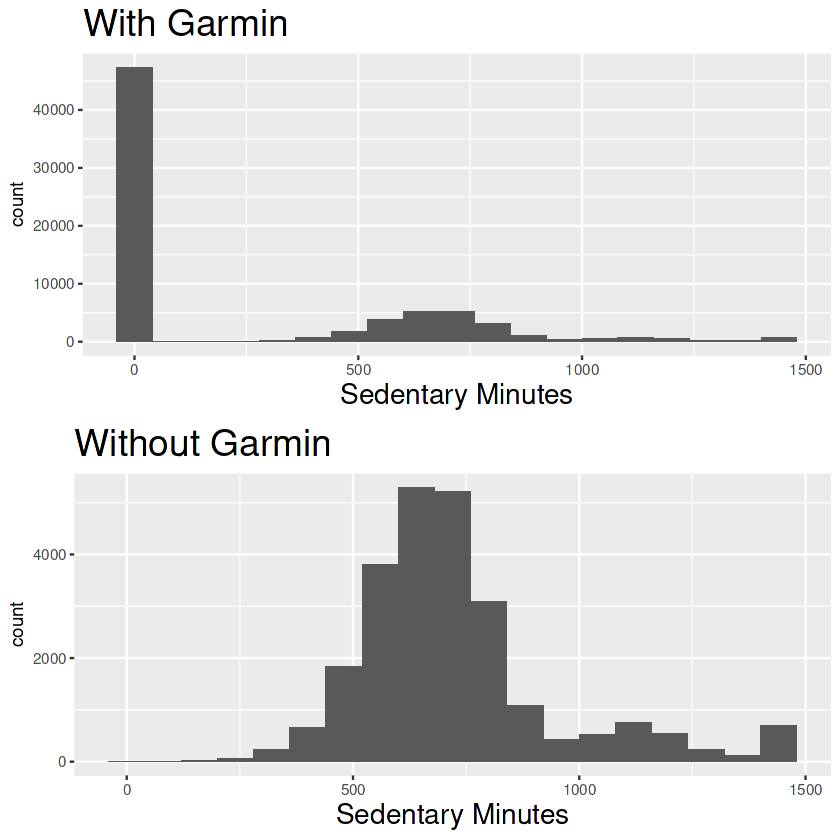

In [5]:
p1 <- ggplot(covid_data, aes(x = Sedentary)) + geom_histogram(binwidth = 80) +
  labs(title = "With Garmin") + theme(plot.title = element_text(size = rel(2)), axis.title.x = element_text(size = rel(1.5))) + xlab("Sedentary Minutes")
p2 <- ggplot(covid_fitbit, aes(x = Sedentary)) + geom_histogram(binwidth = 80) +
  labs(title= "Without Garmin", ) + theme(plot.title = element_text(size = rel(2)), axis.title.x = element_text(size = rel(1.5))) + xlab("Sedentary Minutes")

grid.arrange(p1, p2)

As you can see, there are **far more entries for 0 Sedentary minutes** in the first graph than should be present, and filtering for Fitbit trackers **solves the issue completely**.

The same can be seen for Light Physical Activity entries.

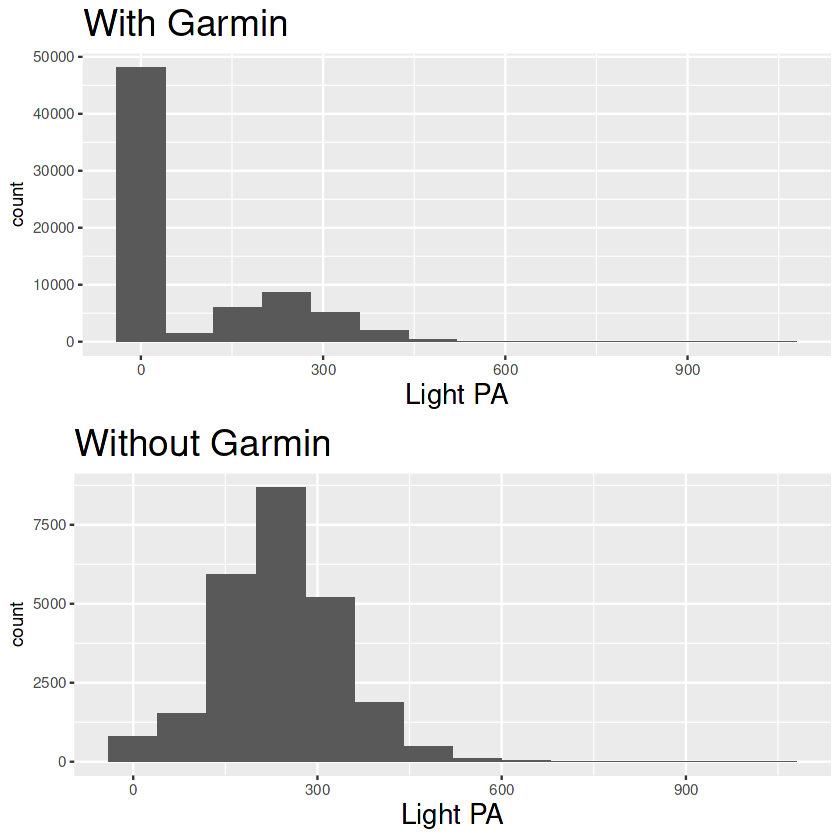

In [6]:
p1 <- ggplot(covid_data, aes(x = LPA)) + geom_histogram(binwidth = 80) +
  labs(title = "With Garmin") + theme(plot.title = element_text(size = rel(2)), axis.title.x = element_text(size = rel(1.5))) + xlab("Light PA")
p2 <- ggplot(covid_fitbit, aes(x = LPA)) + geom_histogram(binwidth = 80) +
  labs(title= "Without Garmin") + theme(plot.title = element_text(size = rel(2)), axis.title.x = element_text(size = rel(1.5))) + xlab("Light PA")

grid.arrange(p1, p2)

For this reason, analysis was conducted strictly on participants **using Fitbit trackers**, and on entries with **more than 0 measured steps**, to find more accurate insights. 

**Dataset #2** (which only used Fitbit trackers) was also filtered to only include entries **with steps measured**, as these days the participant likely did not use their fitness tracker.

In [7]:
activity <- activity %>% 
  filter(TotalSteps != 0) # - removing invalid entries

## Transformations

- A column for "day of the week" was **added** to **both datasets** to create more opportunities for exploration and visuals.
- The **activity** and **sleep** tables in Dataset #2 were **merged** to compare activity and sleep data.

In [8]:
## Adding weekday columns
covid_fitbit$Date_entry <- as.Date(x = covid_fitbit$Date_entry, format = '%m/%d/%Y')
covid_fitbit$WeekDay <- as.numeric(format(covid_fitbit$Date_entry, format='%w'))
covid_fitbit$WeekDay <- recode(covid_fitbit$WeekDay,
                                          "0" = "Sunday",
                                          "1" = "Monday",
                                          "2" = "Tuesday",
                                          "3" = "Wednesday",
                                          "4" = "Thursday",
                                          "5" = "Friday",
                                          "6" = "Saturday")
activity$ActivityDate <- as.Date(x = activity$ActivityDate, format = '%m/%d/%Y')
activity$WeekDay <- as.numeric(format(activity$ActivityDate, format='%w'))
activity$WeekDay <- recode(activity$WeekDay,
                                          "0" = "Sunday",
                                          "1" = "Monday",
                                          "2" = "Tuesday",
                                          "3" = "Wednesday",
                                          "4" = "Thursday",
                                          "5" = "Friday",
                                          "6" = "Saturday")

## adjusting factor levels for visuals
covid_fitbit$WeekDay <- factor(covid_fitbit$WeekDay, 
                        levels = c("Sunday", "Monday", "Tuesday", 
                                   "Wednesday", "Thursday", "Friday", 
                                   "Saturday"))
activity$WeekDay <- factor(activity$WeekDay, 
                        levels = c("Sunday", "Monday", "Tuesday", 
                                   "Wednesday", "Thursday", "Friday", 
                                   "Saturday"))
## merging data
activity_and_sleep <- merge(activity, sleep, by=c("Id","date"))

Now the data can be properly **explored** and **analyzed** for insights.


## Exploration

Next we will explore some **statistics** of relevant columns. 

In [9]:
# Dataset 1
covid_fitbit %>%
  select(Steps, LPA, MPA, VPA, Sedentary) %>% 
  summary()

     Steps            LPA              MPA              VPA        
 Min.   :    4   Min.   :   0.0   Min.   :  0.00   Min.   :  0.00  
 1st Qu.: 6347   1st Qu.: 179.0   1st Qu.:  4.00   1st Qu.:  1.00  
 Median : 9319   Median : 237.0   Median : 15.00   Median : 17.00  
 Mean   :10014   Mean   : 239.3   Mean   : 23.08   Mean   : 30.37  
 3rd Qu.:12902   3rd Qu.: 299.0   3rd Qu.: 32.00   3rd Qu.: 48.00  
 Max.   :50208   Max.   :1080.0   Max.   :451.00   Max.   :630.00  
   Sedentary     
 Min.   :   0.0  
 1st Qu.: 592.0  
 Median : 686.0  
 Mean   : 726.3  
 3rd Qu.: 788.0  
 Max.   :1440.0  

In [10]:
# Dataset 2
activity %>% 
  select (TotalSteps, 
          LightlyActiveMinutes,
          FairlyActiveMinutes,
          VeryActiveMinutes, 
          SedentaryMinutes) %>% 
  summary()

sleep %>% 
select (TotalMinutesAsleep) %>%
summary()

   TotalSteps    LightlyActiveMinutes FairlyActiveMinutes VeryActiveMinutes
 Min.   :    4   Min.   :  0.0        Min.   :  0.00      Min.   :  0.00   
 1st Qu.: 4923   1st Qu.:146.5        1st Qu.:  0.00      1st Qu.:  0.00   
 Median : 8053   Median :208.0        Median :  8.00      Median :  7.00   
 Mean   : 8319   Mean   :210.0        Mean   : 14.78      Mean   : 23.02   
 3rd Qu.:11092   3rd Qu.:272.0        3rd Qu.: 21.00      3rd Qu.: 35.00   
 Max.   :36019   Max.   :518.0        Max.   :143.00      Max.   :210.00   
 SedentaryMinutes
 Min.   :   0.0  
 1st Qu.: 721.5  
 Median :1021.0  
 Mean   : 955.8  
 3rd Qu.:1189.0  
 Max.   :1440.0  

 TotalMinutesAsleep
 Min.   : 58.0     
 1st Qu.:361.0     
 Median :433.0     
 Mean   :419.5     
 3rd Qu.:490.0     
 Max.   :796.0     

### Observations:

* All shared columns between the datasets have similar means, so the data is somewhat **consistent** across sources.

* Dataset #1 had participants that were generally **more active**.

* Average sleep is about **7 hours**, which is the average amount **needed by adults** [1]. 

* Average sedentary time was around **12 hours** - subtracting sleep, this is **5 hours** on average.
    * According to a study published by the National Library of Medicine, average sedentary time for Americans is normally **7.7 hours**, so this group's average is **35% less** [2].
    * This decrease could be related to **using fitness trackers** and being **more mindful** of one's physical activity.

## Visuals

Let's take a look at some **graphs** to **understand** this fitness tracker data.

### <u>Visual #1</u>

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


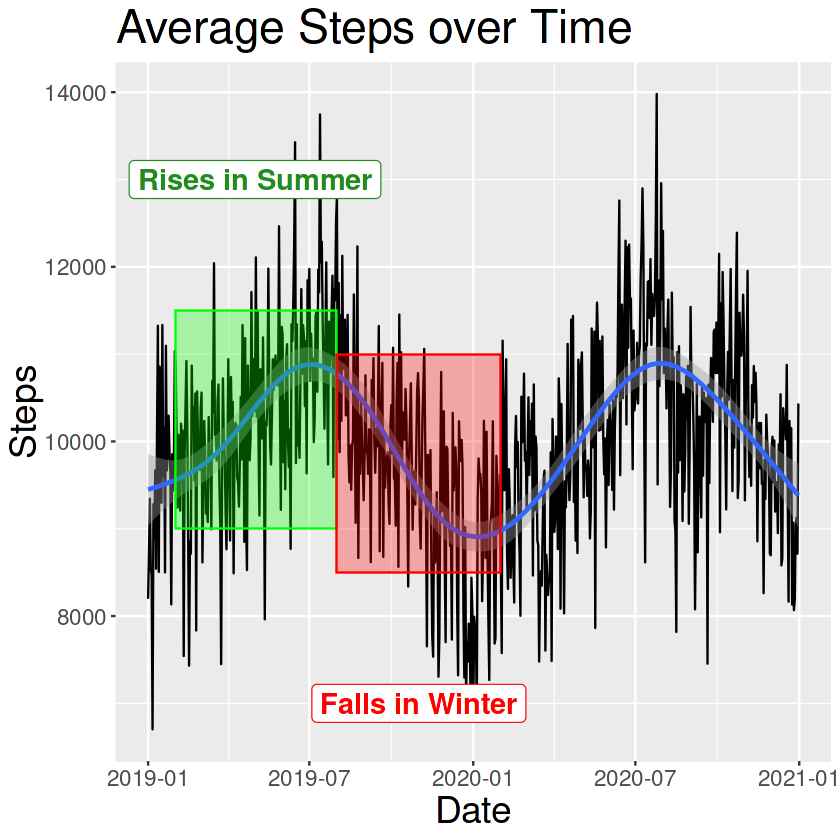

In [11]:
 # Average Steps over time
covid_fitbit %>% 
ggplot(aes(x = Date_entry, y = Steps)) +
geom_line(stat = "summary", fun = "mean") +
geom_smooth() + 
labs(
    title = "Average Steps over Time"
) + 
xlab("Date") + 
theme(plot.title = element_text(size = rel(2.5)), 
      axis.title.x = element_text(size = rel(2)), 
      axis.title.y = element_text(size = rel(2)), 
      axis.text.x = element_text(size = rel(1.5)),
      axis.text.y = element_text(size = rel(1.5))) +
annotate("label", label = c("Rises in Summer","Falls in Winter"), 
           x = c(ymd(20190501), ymd(20191101)), y = c(13000, 7000), 
           size = 6, color = c("forestgreen","red"), fontface = "bold") + 
  annotate("rect", xmin = ymd(20190201), xmax = ymd(20190801), ymin = 9000, ymax = 11500, 
           alpha = 0.3, color = "green", fill = "green") +
  annotate("rect", xmin = ymd(20190801), xmax = ymd(20200201), ymin = 11000, ymax = 8500, 
           alpha = 0.3, color = "red", fill = "red")



### Insights

- Average steps:
    - **Rise** and peak in **summer**
    - **Fall** and hit a minimum in **winter**
    
### <u>Visual #2</u>

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


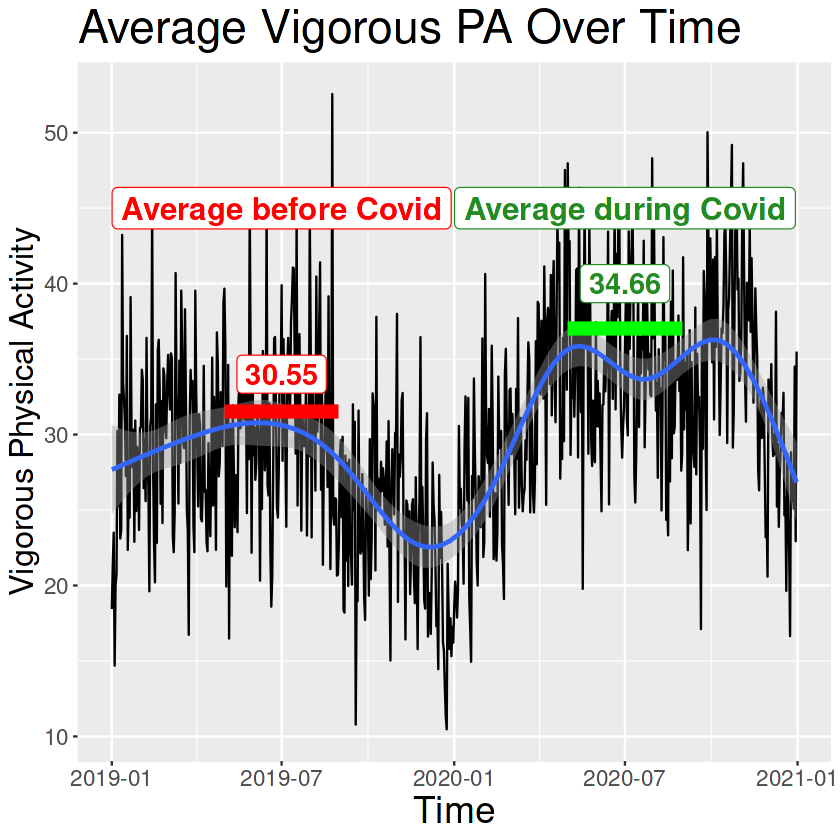

In [12]:
# Average VPA over time
ggplot(covid_fitbit, aes(x = Date_entry, y = VPA)) +
  geom_line(stat = "summary", fun = "mean") + 
  geom_smooth() + 
theme(plot.title = element_text(size = rel(2.5)), 
      axis.title.x = element_text(size = rel(2)), 
      axis.title.y = element_text(size = rel(1.75)), 
      axis.text.x = element_text(size = rel(1.5)),
      axis.text.y = element_text(size = rel(1.5))) +
labs(
    title = "Average Vigorous PA Over Time"
  ) + 
  xlab("Time") +
  ylab("Vigorous Physical Activity") +
annotate("label", label = c("Average before Covid", "Average during Covid"),
           x = c(ymd(20190701),ymd(20200701)), y = c(45, 45), size = 6.5, 
           color = c("red", "forestgreen"), fontface = "bold") + 
  annotate("segment", x = c(ymd(20190501), ymd(20200501)), 
           xend = c(ymd(20190831), ymd(20200831)), y = c(31.5,37), 
           yend = c(31.5,37), color = c("red", "green"), size = 3) + 
  annotate("label", label = c("30.55", "34.66"), x = c(ymd(20190701), 
           ymd(20200701)), y = c(34,40), color = c("red", "forestgreen"), 
           size = 6, fontface = "bold")

### Insights

While following a **similar trend** to the Steps graph, the summer during Covid reaches a **higher peak level**.
- A national emergency for Covid-19 was officially declared March 13th, 2020 [3].

**By how much did average VPA increase**?

#### Calculation of Percent Increase

In [13]:
## Creating Summer Data Frames
covid_fitbit_peak_2020 <- covid_fitbit %>% 
    filter(Date_entry >= "2020-05-01" & Date_entry <= "2020-08-31")
  
covid_fitbit_peak_2019 <- covid_fitbit %>% 
    filter(Date_entry >= "2019-05-01" & Date_entry <= "2019-08-31")

## Percent Change Calculation
round_any((mean(covid_fitbit_peak_2020$VPA) - mean(covid_fitbit_peak_2019$VPA))/mean(covid_fitbit_peak_2019$VPA) * 100, accuracy = .01)

[1] 13.47

The average Vigorous PA rose by **13.47%** during the Covid pandemic, and could be correlated to it.

### <u>Visual #3</u>

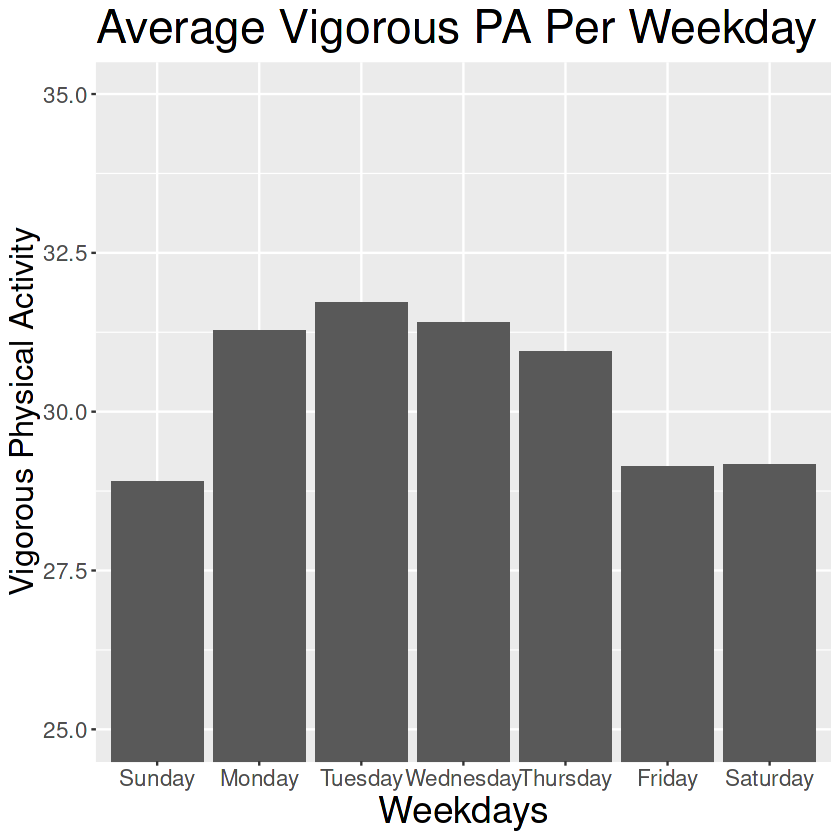

In [14]:
# Average VPA by Weekday
covid_fitbit %>% 
  ggplot(aes(x = WeekDay, y = VPA)) +
  geom_bar(stat = "summary", fun = "mean")+ 
theme(plot.title = element_text(size = rel(2.5)), 
      axis.title.x = element_text(size = rel(2)), 
      axis.title.y = element_text(size = rel(1.75)), 
      axis.text.x = element_text(size = rel(1.5)),
      axis.text.y = element_text(size = rel(1.5))) +
coord_cartesian(ylim = c(25,35)) +
labs(
    title = "Average Vigorous PA Per Weekday"
  ) + 
  xlab("Weekdays") +
  ylab("Vigorous Physical Activity")

### Insights
- The average Vigorous PA **rises** during **weekdays**.
- Average VPA is at a steady, **lower level** during the **weekend**.

These differences could be due to the **work schedules** of participants.

### <u>Visual #4</u>

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


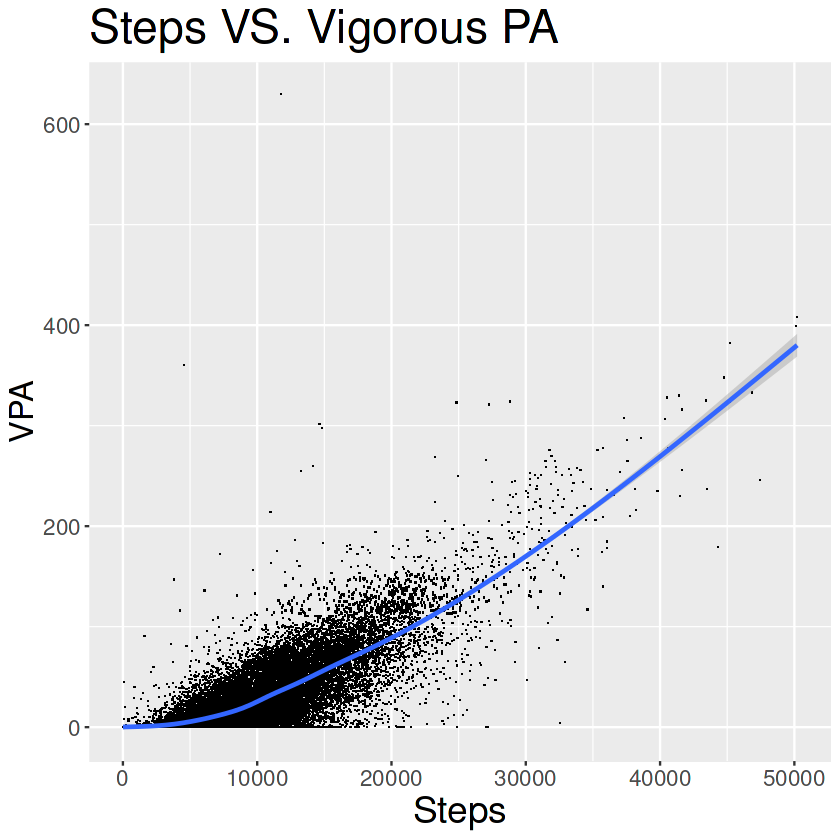

In [15]:
# Steps vs. VPA
covid_fitbit %>% 
  ggplot(aes(x = Steps, y = VPA)) + 
  geom_point(shape = ".") +
  geom_smooth()+ 
theme(plot.title = element_text(size = rel(2.5)), 
      axis.title.x = element_text(size = rel(2)), 
      axis.title.y = element_text(size = rel(1.75)), 
      axis.text.x = element_text(size = rel(1.5)),
      axis.text.y = element_text(size = rel(1.5))) +
labs(
    title = "Steps VS. Vigorous PA"
)
# show regression line + coefficient


To understand the **significance** of this scatterplot, we will use **linear regression**.
### Linear Regression Statistics

In [16]:
steps_vs_vpa <- lm(Steps ~ VPA, data = covid_fitbit)
summary(steps_vs_vpa)


Call:
lm(formula = Steps ~ VPA, data = covid_fitbit)

Residuals:
   Min     1Q Median     3Q    Max 
-64293  -2142   -195   1922  25411 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6669.3500    27.0124   246.9   <2e-16 ***
VPA          110.1224     0.5606   196.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3291 on 24623 degrees of freedom
Multiple R-squared:  0.6104,	Adjusted R-squared:  0.6104 
F-statistic: 3.858e+04 on 1 and 24623 DF,  p-value: < 2.2e-16


### Insights
- R-squared = 0.61
    - This means **61%** of the **variation in VPA** is likely caused by the Steps variable, which gives credibility to the **moderate positive relationship** seen in the visual.
- P value = 2.2e-16 (very close to zero)
    - A **lower** p value means a **greater statistical significance** for this model.
    
These regression statistics indicate that the relationship between VPA and Steps is **statistically significant** and **moderately positive**, meaning an increase in Steps **consistently correlates** with an increase in Vigorous PA.

### <u>Visual #5</u>

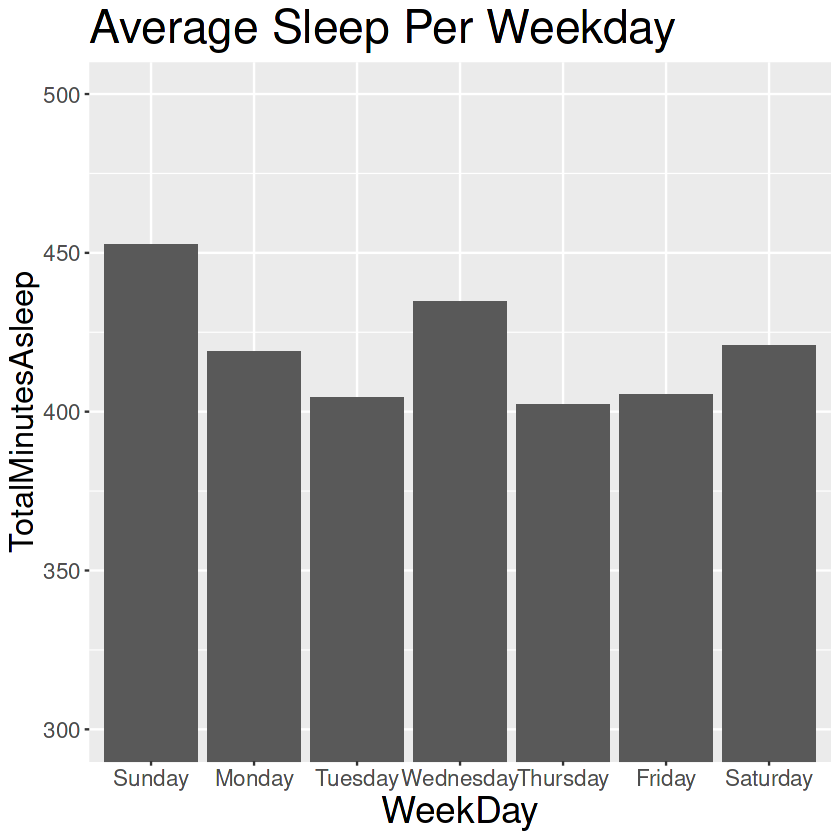

In [17]:
# Sleep by day of week
activity_and_sleep %>% 
  ggplot(aes(x = WeekDay, y = TotalMinutesAsleep)) + 
  geom_bar(stat = "summary", fun = "mean") + 
theme(plot.title = element_text(size = rel(2.5)), 
      axis.title.x = element_text(size = rel(2)), 
      axis.title.y = element_text(size = rel(1.75)), 
      axis.text.x = element_text(size = rel(1.5)),
      axis.text.y = element_text(size = rel(1.5))) +
labs(
    title = "Average Sleep Per Weekday"
) + 
coord_cartesian(ylim = c(300,500))

### Insights
- Average sleep levels are:
    - **highest** surrounding the **weekend**
    - **lowest** during the **week**, and
    - spike on Wednesdays.
    
These trends could be related to the **work schedules** of participants, or even **cultural values** of the weekend being a "time of rest", but require **further research**.

Additionally, a spike on Wednesdays is unexpected and may be worth further exploration.

## Recommendations

#### 1. Targeting Gyms, Exercise Groups, and Fitness Influencers in the Summer

<img src=https://sp-ao.shortpixel.ai/client/to_webp,q_glossy,ret_img,w_1024/https://www.sci-tech-today.com/wp-content/uploads/2024/06/zAlHb-fitbit-user-by-age--1024x476.png width="500">


**Working class** and **younger users** are Fitbit's largest customer group (see chart above) [4]. In addition, **millenials** and **Generation Z** are becoming more **aware** of their physical and mental health [5].
    
Therefore, targeting different **places** and **platforms** that these generations **use** for health and fitness will allow Bellabeat to achieve more **awareness** among customers. 

**Gyms** and **Exercise Groups** can be used to:
- recruit **ambassadors**
- give members of these gyms/groups **discounts** on fitness trackers (more exposure)

**Social media** can continue to be a primary communication medium for these groups using:
- **advertisements**
- **partnerships** with social media influencers
- creating social media **ambassadors**

Visuals #1 and #2 showed **heightened activity levels** during **summer** months.

Using **gyms**, **exercise groups**, and **social media influencers** can apply to Bellabeat's marketing generally, but focusing its resources towards **summer** months, when many people are more active, may produce better results.

#### 2. Partnerships with Corporate Fitness companies

The work week of Monday to Friday is correlated with **higher activity levels**, as seen in visual #3. This could be due to **walking** during work, or **regular exercise** before/after work.

Visual #5 demonstrated **lower sleep levels** during the week, which may indicate a **negative relationship** between work and sleep for most people. Companies that wish to have healthy employees could benefit from the **increased health awareness** that fitness trackers provide.

The **top 2 fitness trends** predicted for 2024 are **wearable technology** and **worksite health promotion**, according to the American College of Sports Medicine [6].

Bellabeat could **partner** with companies like Corporate Fitness Works, a female-owned company that designs corporate fitness programs, to sell the IVY+ or Leaf Urban as part of their **programs** to any women who wish to opt into using one. Doing so may create more **revenue** and **product exposure**.

#### 3. Framing Using Familial Values in Winter

**Visuals #1 and #2** showed **lower activity levels** during **winter** months. 

As opposed to the first recommendation, marketing efforts during the **winter** could instead be pointed to **framing** the IVY+ or Leaf Urban as **emotionally positive** products for family through **currently used advertising methods**. 

Engaging in more **low intensity activity** with family, such as walking or playing games, can create **deeper connections** through shared experiences [7]. **Higher physical activity** levels are also highly correlated with increased **happiness and life satisfaction** [8]. 

This would also build on the increased presence of **holidays** that emphasize **familial values**, such as Thanksgiving and Christmas. **Framing** the IVY+ or Leaf Urban in this way through advertising would likely **increase their appeal** to customers.


#### 4. Educating the Customer Base

**Visual #2** demonstrates a sizeable **increase** in intense physical activity during the **Covid pandemic**. This could be due to many reasons, but a plausible one is widespread quarantine and less face-to-face social activity. 

**Visual #4** shows a significant **positive relationship** between intense physical activity and step count, meaning emphasizing either will have an **overall effect** on reaching **healthy activity levels**. 

**Reminding** customers of the **benefits** of exercise, and the ability to accurately **track** that exercise, may persuade more people to **buy** the IVY+ or Leaf Urban trackers.

Many people reported **higher levels of stress** during this time, and have likely been **negatively affected** by such long term stress [9]. An increased level of physical activity during Covid may have been an effort to **alleviate stress**, or individuals simply had more time to. 

Intense physical activity is also proven to benefit **mental health** in individuals of any gender or age group [10], and **framing** the IVY+ or Leaf Urban in this context may increase its **appeal** to customers through **currently used advertising methods**. 

## Sources
1. Suni, Eric, and Abhinav Singh. “How Much Sleep Do You Need?” Sleep Foundation, 13 May 2024, www.sleepfoundation.org/how-sleep-works/how-much-sleep-do-we-really-need. 
2. Park JH, Moon JH, Kim HJ, Kong MH, Oh YH. Sedentary Lifestyle: Overview of Updated Evidence of Potential Health Risks. Korean J Fam Med. 2020 Nov;41(6):365-373. doi: 10.4082/kjfm.20.0165. Epub 2020 Nov 19. PMID: 33242381; PMCID: PMC7700832.
3. “CDC Museum Covid-19 Timeline.” Centers for Disease Control and Prevention, Centers for Disease Control and Prevention, 15 Mar. 2023, www.cdc.gov/museum/timeline/covid19.html. 
4. Joshi, Ketaki. “Fitbit Statistics by Consumer Usage Habit and Revenue.” Sci, 18 June 2024, www.sci-tech-today.com/stats/fitbit-statistics/#Fitbit_Statistics_By_Demographics. 
5. “Study Shows Younger Generations Are More Health-Conscious than Previous Generations.” Texas Health Resources, 25 Apr. 2023, www.texashealth.org/areyouawellbeing/Health-and-Well-Being/Study-Shows-Younger-Generations-Are-More-Health-Conscious-Than-Previous-Generations. 
6. “ACSM’s Health & Fitness Journal® Releases Top Fitness Trends for 2024.” American College of Sports Medicine, 10 Jan. 2024, www.acsm.org/news-detail/2024/01/10/acsm-s-health-fitness-journal-releases-top-fitness-trends-for-2024. 
7. Stanfield, Jennifer. “Three Reasons Why Physical Activity Should Be a Family Routine.” ACE Insight, 14 Nov. 2019, www.acefitness.org/resources/everyone/blog/7418/three-reasons-why-physical-activity-should-be-a-family-routine/. 
8. An HY, Chen W, Wang CW, Yang HF, Huang WT, Fan SY. The Relationships between Physical Activity and Life Satisfaction and Happiness among Young, Middle-Aged, and Older Adults. Int J Environ Res Public Health. 2020 Jul 4;17(13):4817. doi: 10.3390/ijerph17134817. PMID: 32635457; PMCID: PMC7369812. 
9. Bethune, Sophie. “Stress in America 2023: A Nation Recovering from Collective Trauma.” American Psychological Association, American Psychological Association, Nov. 2023, www.apa.org/news/press/releases/stress/2023/collective-trauma-recovery. 
10. Mahindru A, Patil P, Agrawal V. Role of Physical Activity on Mental Health and Well-Being: A Review. Cureus. 2023 Jan 7;15(1):e33475. doi: 10.7759/cureus.33475. PMID: 36756008; PMCID: PMC9902068.


Thank you for reading this case study! As it is my first, I would love any criticisms or comments to improve. 

Have a great day!

Sincerely, Carson